# Household Location Choice Model (HLCM) for Single and Multi Family Housing  


Arezoo Besharati, Paul Waddell, UrbanSim, July 2018 

This notebook demonstrates the use of the LargeMultinomialLogit model template to construct, estimate, and evaluate a Household Location Choice Model for the San Francisco Bay Area.

In the process of developing the model, we also demonstrate some data checking and transformations to improve the model.

The model structure and specification are informed and limited by the available data, which is based on the data used by the Metropolitan Transportation Commission for their operational model.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminaries</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Initialize-Networks" data-toc-modified-id="Initialize-Networks-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Initialize Networks</a></span></li><li><span><a href="#Explore-the-data" data-toc-modified-id="Explore-the-data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Explore the data</a></span></li><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Perform-desired-variable-creations-and-transformations¶" data-toc-modified-id="Perform-desired-variable-creations-and-transformations¶-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Perform desired variable creations and transformations¶</a></span></li><li><span><a href="#Check-Distributions" data-toc-modified-id="Check-Distributions-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Check Distributions</a></span></li><li><span><a href="#Check-for-Multicollinearity" data-toc-modified-id="Check-for-Multicollinearity-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Check for Multicollinearity</a></span></li></ul></li><li><span><a href="#Model-Estimation" data-toc-modified-id="Model-Estimation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Estimation</a></span><ul class="toc-item"><li><span><a href="#HLCM-for-Multi-Family" data-toc-modified-id="HLCM-for-Multi-Family-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>HLCM for Multi-Family</a></span></li><li><span><a href="#HLCM-for-Single-Family" data-toc-modified-id="HLCM-for-Single-Family-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>HLCM for Single-Family</a></span></li></ul></li></ul></div>

## Preliminaries

In [1]:
import os; os.chdir('../../')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Load data

In [4]:
# Load any script-based Orca registrations
from scripts import datasources
from scripts import models

In [ ]:
orca.list_tables()
#orca.list_broadcasts()
#orca.list_steps()

In [ ]:
#mm.list_steps()

In [ ]:
#mm.initialize()

### Initialize Networks

Note that we have separately created a set of network accessibility variables and stored them. They are registered a orca objects.

In [5]:
%%capture
orca.run(["initialize_network_walk"])

In [7]:
%%capture
orca.run(["initialize_network_small"])

### Explore the data

In [ ]:
parcel = orca.get_table('parcels').to_frame()
#parcel.columns

In [22]:
bld = orca.get_table('buildings').to_frame()
#bld.columns

In [20]:
hh = orca.get_table('households').to_frame()
#hh.columns.tolist()

In [ ]:
#bld.groupby('building_type_id')['residential_units'].sum()

In [ ]:
#bld.describe().transpose()

In [ ]:
#bld.quantile(.99)

In [ ]:
#bld[['residential_units','residential_sqft', 'non_residential_sqft']].sum()

In [ ]:
#bld.building_type_id.value_counts()

In [ ]:
hh_sf=hh[hh['building_type']==2]
hh_mf=hh[hh['building_type']!=2]

### Data Cleaning

In [8]:
nodeswalk = orca.get_table('nodeswalk').to_frame()
nodessmall = orca.get_table('nodessmall').to_frame()
#print(nodeswalk.columns.tolist())
#print(nodessmall.columns.tolist())

In [ ]:
#nodessmall.describe().transpose()

In [9]:
nodessmall_upper = nodessmall.quantile(.99)
#nodessmall_upper

In [10]:
nodessmall_clipped = nodessmall.clip_upper(nodessmall_upper, axis=1) 
nodessmall_clipped.describe().transpose()
orca.add_table('nodessmall', nodessmall_clipped);

In [11]:
nodeswalk.describe().transpose()
nodeswalk_upper = nodeswalk.quantile(.99)
#nodeswalk_upper

In [12]:
nodeswalk_clipped = nodeswalk.clip_upper(nodeswalk_upper, axis=1) 
nodeswalk_clipped.describe().transpose()
orca.add_table('nodeswalk', nodeswalk_clipped);

### Perform desired variable creations and transformations¶

In [23]:
# scale income and create race dummies
hh.income_k = hh.income/1000
hh.white = (hh.race_of_head == 1).astype(int)
hh.black = (hh.race_of_head == 2).astype(int)
hh.asian = (hh.race_of_head == 6).astype(int)
hh.hisp = (hh.hispanic_head == 'yes').astype(int)
hh.single = (hh.persons == 1).astype(int)
hh.elderly = (hh.age_of_head > 65).astype(int)

  
# building_type dummies
bld.single_family = (bld.building_type_id == 1).astype(int)
bld.multi_family = (bld.building_type_id == 3).astype(int)
bld.mixed_use = (bld.building_type_id > 3).astype(int)

# add the columns

orca.add_column('households', 'income_k', hh.income_k)
orca.add_column('households', 'white', hh.white)
orca.add_column('households', 'black', hh.black)
orca.add_column('households', 'asian', hh.asian)
orca.add_column('households', 'hispanic', hh.hisp)
orca.add_column('households', 'elderly', hh.elderly)
orca.add_column('households', 'single', hh.single)

orca.add_column('buildings', 'single_family', bld.single_family)
orca.add_column('buildings', 'multi_family', bld.multi_family)
orca.add_column('buildings', 'mixed_use', bld.mixed_use);

In [24]:
nodeswalk['prop_children_500_walk'] = (nodeswalk['children_500_walk'] > 0).astype(int) / nodeswalk['hh_500_walk']
nodeswalk['prop_singles_500_walk'] = nodeswalk['singles_500_walk'] / nodeswalk['hh_500_walk']
nodeswalk['prop_elderly_500_walk'] = nodeswalk['elderly_hh_500_walk'] / nodeswalk['hh_500_walk']
nodeswalk['prop_black_500_walk'] = nodeswalk['pop_black_500_walk'] / nodeswalk['pop_500_walk']
nodeswalk['prop_white_500_walk'] = nodeswalk['pop_white_500_walk'] / nodeswalk['pop_500_walk']
nodeswalk['prop_asian_500_walk'] = nodeswalk['pop_asian_500_walk'] / nodeswalk['pop_500_walk']
nodeswalk['prop_hisp_500_walk'] = nodeswalk['pop_hisp_500_walk'] / nodeswalk['pop_500_walk']
nodeswalk['prop_rich_500_walk'] = nodeswalk['rich_500_walk'] / nodeswalk['pop_500_walk']
nodeswalk['prop_poor_500_walk'] = nodeswalk['poor_500_walk'] / nodeswalk['pop_500_walk']

nodeswalk['prop_children_1500_walk'] = (nodeswalk['children_1500_walk'] > 0).astype(int) / nodeswalk['hh_1500_walk']
nodeswalk['prop_singles_1500_walk'] = nodeswalk['singles_1500_walk'] / nodeswalk['hh_1500_walk']
nodeswalk['prop_elderly_1500_walk'] = nodeswalk['elderly_hh_1500_walk'] / nodeswalk['hh_1500_walk']
nodeswalk['prop_black_1500_walk'] = nodeswalk['pop_black_1500_walk'] / nodeswalk['pop_1500_walk']
nodeswalk['prop_white_1500_walk'] = nodeswalk['pop_white_1500_walk'] / nodeswalk['pop_1500_walk']
nodeswalk['prop_asian_1500_walk'] = nodeswalk['pop_asian_1500_walk'] / nodeswalk['pop_1500_walk']
nodeswalk['prop_hisp_1500_walk'] = nodeswalk['pop_hisp_1500_walk'] / nodeswalk['pop_1500_walk']
nodeswalk['prop_rich_1500_walk'] = nodeswalk['rich_1500_walk'] / nodeswalk['pop_1500_walk']
nodeswalk['prop_poor_1500_walk'] = nodeswalk['poor_1500_walk'] / nodeswalk['pop_1500_walk']


orca.add_column('nodeswalk', 'prop_children_500_walk', nodeswalk['prop_children_500_walk'])
orca.add_column('nodeswalk', 'prop_singles_500_walk', nodeswalk['prop_singles_500_walk'])
orca.add_column('nodeswalk', 'prop_elderly_500_walk', nodeswalk['prop_elderly_500_walk'])
orca.add_column('nodeswalk', 'prop_black_500_walk', nodeswalk['prop_black_500_walk'])
orca.add_column('nodeswalk', 'prop_white_500_walk', nodeswalk['prop_white_500_walk'])
orca.add_column('nodeswalk', 'prop_asian_500_walk', nodeswalk['prop_asian_500_walk'])
orca.add_column('nodeswalk', 'prop_hisp_500_walk', nodeswalk['prop_hisp_500_walk'])
orca.add_column('nodeswalk', 'prop_rich_500_walk', nodeswalk['prop_rich_500_walk'])
orca.add_column('nodeswalk', 'prop_poor_500_walk', nodeswalk['prop_poor_500_walk'])

orca.add_column('nodeswalk', 'prop_children_1500_walk', nodeswalk['prop_children_1500_walk'])
orca.add_column('nodeswalk', 'prop_singles_1500_walk', nodeswalk['prop_singles_1500_walk'])
orca.add_column('nodeswalk', 'prop_elderly_1500_walk', nodeswalk['prop_elderly_1500_walk'])
orca.add_column('nodeswalk', 'prop_black_1500_walk', nodeswalk['prop_black_1500_walk'])
orca.add_column('nodeswalk', 'prop_white_1500_walk', nodeswalk['prop_white_1500_walk'])
orca.add_column('nodeswalk', 'prop_asian_1500_walk', nodeswalk['prop_asian_1500_walk'])
orca.add_column('nodeswalk', 'prop_hisp_1500_walk', nodeswalk['prop_hisp_1500_walk'])
orca.add_column('nodeswalk', 'prop_rich_1500_walk', nodeswalk['prop_rich_1500_walk'])
orca.add_column('nodeswalk', 'prop_poor_1500_walk', nodeswalk['prop_poor_1500_walk'])

### Check Distributions

In [ ]:
# hh_income_upper = hh_singlefamily.income.quantile(0.99)
# len(hh[hh['income']>hh_income_upper])

In [ ]:
# %matplotlib notebook
# hh_sf.income.plot(kind='hist',bins=100)
# print(hh_sf.income.quantile([0.10,0.5,0.9,0.99,1]))

In [ ]:
# %matplotlib notebook
# hh_mf.income.plot(kind='hist',bins=100)
# print(hh_mf.income.quantile([0.10,0.5,0.9,0.99,1]))

In [ ]:
# %matplotlib notebook
# ax = sns.boxplot(x = hh_sf.income,palette="Set2", width=0.5)

In [ ]:
# %matplotlib notebook
# ax = sns.boxplot(x = hh_mf.income,palette="Set2", width=0.5)

In [15]:
df = orca.merge_tables(target = 'buildings', tables = ['buildings','parcels','nodeswalk','nodessmall'])
#df.columns.tolist()
df_sf= df[df['residential_units']==1]
df_mf= df[df['residential_units']>1]

In [ ]:
# %matplotlib notebook
# df_sf.avg_income_1500_walk.plot(kind='hist',bins=100)
# plt.show()
# print(df_sf.avg_income_1500_walk.quantile([0.10,0.5,0.9,0.99,1]))

In [ ]:
# %matplotlib notebook
# df_mf.avg_income_1500_walk.plot(kind='hist',bins=100)
# plt.show()
# print(df_mf.avg_income_1500_walk.quantile([0.10,0.5,0.9,0.99,1]))

In [ ]:
#%matplotlib notebook
#(df_mf.prop_black_500_walk).plot(kind='hist',bins=100)
#(df_mf.prop_asian_500_walk).plot(kind='hist',bins=100)
#(df_mf.prop_white_500_walk).plot(kind='hist',bins=100)
#(df_mf.prop_hisp_500_walk).plot(kind='hist',bins=100)


### Check for Multicollinearity

In [ ]:
# %matplotlib inline
# plt.subplots(figsize=(20, 20))


# # Create correlation matrix
# corr_matrix = df_sf.corr().abs()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# high_corr = [column for column in upper.columns if any(upper[column] > 0.98)]
# X= df_sf[high_corr]
# sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")

In [ ]:
# %matplotlib inline
# plt.subplots(figsize=(20, 20))

# corr_matrix = df_mf.corr()

# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# high_corr = [column for column in upper.columns if any(upper[column] > 0.95)]
# X= df_mf[high_corr]
# plt.subplots(figsize=(20, 20))
# sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")

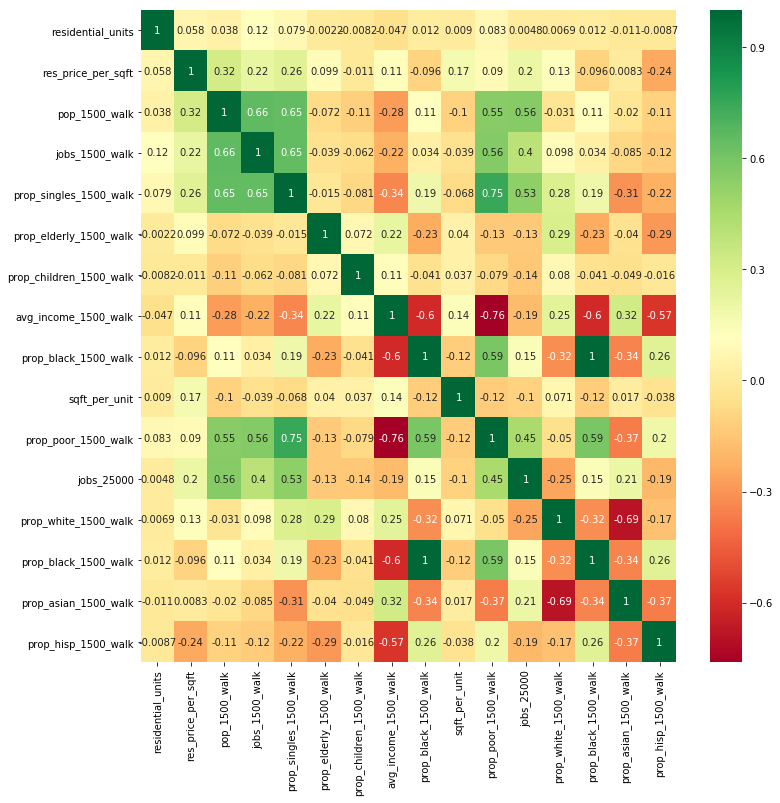

In [16]:
%matplotlib inline

selected_features = ['residential_units','res_price_per_sqft', 'pop_1500_walk', 'jobs_1500_walk',
                     'prop_singles_1500_walk','prop_elderly_1500_walk','prop_children_1500_walk',
                     'avg_income_1500_walk','prop_black_1500_walk', 'sqft_per_unit','prop_poor_1500_walk',
                     'jobs_25000','prop_white_1500_walk','prop_black_1500_walk','prop_asian_1500_walk',
                     'prop_hisp_1500_walk']

X = df_mf[selected_features]

plt.subplots(figsize=(12, 12))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

## Model Estimation

### HLCM for Multi-Family 

In [32]:
%%time
m = LargeMultinomialLogitStep()
m.choosers = ['households']
m.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m.choice_column = 'building_id'
m.alt_sample_size = 50

#Filters on choosers
m.chooser_filters = ['building_type > 2 &\
                      household_id <100000 &\
                      recent_mover == 1 &\
                      0 <income < 500000']

#Filters on alternatives
m.alt_filters = ['residential_units > 1',
                 '0 < avg_income_500_walk < 500000',
                 'pop_1500_walk > 0',
                 'sqft_per_unit > 0']


m.model_expression = ' np.log(residential_units) + \
np.log1p(res_price_per_sqft) + \
np.log1p(sqft_per_unit) + \
np.log1p(income):np.log1p(sqft_per_unit) + \
np.log1p(jobs_1500_walk) + \
np.log1p(jobs_25000) + \
np.log(income):np.log(avg_income_1500_walk) + \
np.log1p(pop_1500_walk) + \
white:prop_white_500_walk + \
black:prop_black_500_walk + \
asian:prop_asian_500_walk + \
hispanic:prop_hisp_500_walk\
- 1'

m.name = 'hlcm'
m.tags = ['multi_family','test']
m.fit()

                  CHOICEMODELS ESTIMATION RESULTS                  
Dep. Var.:                chosen   No. Observations:          1,992
Model:         Multinomial Logit   Df Residuals:              1,981
Method:       Maximum Likelihood   Df Model:                     11
Date:                 2018-07-20   Pseudo R-squ.:             0.325
Time:                      09:29   Pseudo R-bar-squ.:         0.324
AIC:                  10,539.572   Log-Likelihood:       -5,258.786
BIC:                  10,601.138   LL-Null:              -7,792.750
                                              coef   std err         z     P>|z|   Conf. Int.
---------------------------------------------------------------------------------------------
np.log(residential_units)                   0.6794     0.024    28.514     0.000             
np.log1p(res_price_per_sqft)               -0.7279     0.021   -34.863     0.000             
np.log1p(sqft_per_unit)                     1.7961     0.046    38.948     0.000

### HLCM for Single-Family 

In [ ]:
%%time
m = LargeMultinomialLogitStep()
m.choosers = ['households']
m.alternatives = ['buildings','parcels','nodeswalk','nodessmall']
m.choice_column = 'building_id'
m.alt_sample_size = 50

#Filters on choosers
m.chooser_filters = ['building_type == 2 & household_id <3000000 & recent_mover == 1 & 0 <income < 1000000']

#Filters on alternatives
m.alt_filters = ['residential_units == 1',
                 '0 < avg_income_500_walk < 500000',
                 'sqft_per_unit > 0']

# np.log(residential_units) +
# np.log(income):np.log(avg_income_500_walk) + \
# np.log1p(income):np.log1p(rich_1500_walk) + \
# np.log1p(income):np.log1p(poor_1500_walk) + \
# np.log1p(persons):np.log1p(sqft_per_unit) + \

m.model_expression = ' \
np.log1p(res_price_per_sqft) + \
np.log1p(income):np.log1p(res_price_per_sqft) + \
np.log1p(sqft_per_unit) + \
np.log1p(income):np.log1p(sqft_per_unit) + \
np.log1p(acres) + \
np.log1p(income):np.log1p(acres) + \
np.log1p(pop_1500_walk) + \
np.log1p(jobs_1500_walk) + \
np.log1p(jobs_25000) + \
single:np.log1p(singles_1500_walk) + \
elderly:np.log1p(elderly_hh_1500_walk) + \
children:np.log1p(children_1500_walk) + \
white:np.log1p(pop_white_1500_walk) + \
black:np.log1p(pop_black_1500_walk) + \
asian:np.log1p(pop_asian_1500_walk) + \
hispanic:np.log1p(pop_hisp_1500_walk) \
- 1'

m.name = 'hlcm'
m.tags = ['single_family', 'test']
m.fit()